In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConvolution2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Add,Input,concatenate,Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


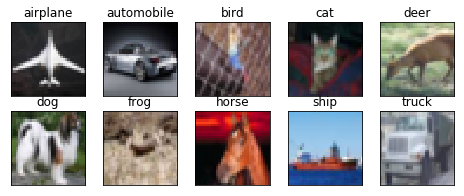

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x1(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=4)

In [19]:
# Define the model
model_input=Input(shape=(img_rows, img_cols,img_channels))

l1=SeparableConvolution2D(32, (5, 5), border_mode='same',name='conv1',use_bias=False)(model_input)
l1=BatchNormalization(name='bn_1')(l1)
l1=Activation('relu')(l1)
l1=Dropout(0.05)(l1)
l1_1=l1
l1_hf=Lambda(space_to_depth_x1)(l1_1)
l1_qt=Lambda(space_to_depth_x2)(l1_1)

l2=Convolution2D(32, (5, 5), border_mode='same', name='ss_conv2',use_bias=False)(l1)
l2=BatchNormalization(name='bn_2')(l2)
l2=Activation('relu')(l2)
l2=Dropout(0.05)(l2)
l2_1=l2
l2_hf=Lambda(space_to_depth_x1)(l2_1)
l2_qt=Lambda(space_to_depth_x2)(l2_1)

l3=Convolution2D(32, (5, 5), border_mode='same', name='ss_conv3',use_bias=False)(l2)
l3=BatchNormalization(name='bn_3')(l3)
l3=Activation('relu')(l3)
l3=Dropout(0.05)(l3)
l3_1=l3
l3_hf=Lambda(space_to_depth_x1)(l3_1)
l3_qt=Lambda(space_to_depth_x2)(l3_1)

concat_1=concatenate([l1,l3])

l4=SeparableConvolution2D(32, (5, 5), border_mode='same', name='s_conv4',use_bias=False)(concat_1)
l4=BatchNormalization(name='bn_4')(l4)
l4=Activation('relu')(l4)
l4=Dropout(0.05)(l4)
l4_1=l4
l4_hf=Lambda(space_to_depth_x1)(l4_1)
l4_qt=Lambda(space_to_depth_x2)(l4_1)

concat_2=concatenate([l1,l4])

mp_1=MaxPooling2D(pool_size=(2, 2))(concat_2)

l5=SeparableConvolution2D(32, (3,3), border_mode='same',name='s_conv4a',use_bias=False)(mp_1)
l5=BatchNormalization(name='bn_5')(l5)
l5=Activation('relu')(l5)
l5=Dropout(0.05)(l5)
l5_1=l5
l5_hf=Lambda(space_to_depth_x1)(l5_1)

concat_3=concatenate([l5,l4_hf,l1_hf])

l6=Convolution2D(32, (5, 5), border_mode='same', name='g_conv5',use_bias=False)(concat_3)
l6=BatchNormalization(name='bn_6')(l6)
l6=Activation('relu')(l6)
l6=Dropout(0.05)(l6)
l6_1=l6
l6_hf=Lambda(space_to_depth_x1)(l6_1)

concat_4=concatenate([l6,l5,l4_hf,l3_hf])

l7=SeparableConvolution2D(32, (3, 3), border_mode='same', name='g_conv6',use_bias=False)(concat_4)
l7=BatchNormalization(name='bn_7')(l7)
l7=Activation('relu')(l7)
l7=Dropout(0.05)(l7)
l7_1=l7
l7_hf=Lambda(space_to_depth_x1)(l7_1)

concat_5=concatenate([l7,l6,l5,l4_hf,l3_hf,l1_hf])

l8=SeparableConvolution2D(32,(5,5),border_mode='same', name='g_conv7',use_bias=False)(concat_5)
l8=BatchNormalization(name='bn_8')(l8)
l8=Activation('relu')(l8)
l8=Dropout(0.05)(l8)
l8_1=l8
l8_hf=Lambda(space_to_depth_x1)(l8_1)

cancat_6=concatenate([l8,l7,l5,l4_hf,l1_hf])

mp_2=MaxPooling2D(pool_size=(2, 2))(cancat_6)

concat_7=concatenate([mp_2,l6_hf])

l9=Convolution2D(32, (5, 5), border_mode='same', name='g_conv8',use_bias=False)(concat_7)
l9=BatchNormalization(name='bn_9')(l9)
l9=Activation('relu')(l9)
l9=Dropout(0.05)(l9)

concat_8=concatenate([l9,l7_hf,l4_qt,l2_qt])

l10=SeparableConvolution2D(32, (5, 5), border_mode='same', name='g_conv9',use_bias=False)(concat_8)
l10=BatchNormalization(name='bn_10')(l10)
l10=Activation('relu')(l10)
l10=Dropout(0.05)(l10)

concat_9= concatenate([l10,l9,l5_hf,l3_qt,l2_qt])

l11=Convolution2D(32,(3,3),border_mode='same', name='g_conv10',use_bias=False)(concat_9)
l11=BatchNormalization(name='bn_11')(l11)
l11=Activation('relu')(l11)
l11=Dropout(0.05)(l11)

concat_10=concatenate([l11,l10,l7_hf,l5_hf,l4_qt,l3_qt,l1_qt])

l12=SeparableConvolution2D(32, (5, 5),border_mode='same', name='g_conv11',use_bias=False)(concat_10)
l12=BatchNormalization(name='bn_12')(l12)
l12=Activation('relu')(l12)
l12=Dropout(0.05)(l12)

concat_10=concatenate([l12,l10,l7_hf,l4_qt])

l13=Convolution2D(10,(8,8), name='g_conv12')(concat_10)

l14=Flatten()(l13)

model_output=Activation('softmax')(l14)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="conv1", use_bias=False, padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="ss_conv2", use_bias=False, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="ss_conv3", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="s_conv4", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

In [20]:
model = Model(inputs=[model_input],outputs=[model_output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (SeparableConv2D)         (None, 32, 32, 32)   171         input_4[0][0]                    
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 32, 32, 32)   0           bn_1[0][0]                       
__________________________________________________________________________________________________
dropout_25

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 48s 123ms/step - loss: 3.9024 - acc: 0.3199 - val_loss: 2.0927 - val_acc: 0.4033
Epoch 2/100
390/390 [==============================] - 42s 108ms/step - loss: 1.8025 - acc: 0.4772 - val_loss: 1.7744 - val_acc: 0.4501
Epoch 3/100
390/390 [==============================] - 43s 109ms/step - loss: 1.3833 - acc: 0.5628 - val_loss: 1.3247 - val_acc: 0.5427
Epoch 4/100
390/390 [==============================] - 43s 109ms/step - loss: 1.0628 - acc: 0.6307 - val_loss: 1.2350 - val_acc: 0.5741
Epoch 5/100
390/390 [==============================] - 43s 109ms/step - loss: 0.9403 - acc: 0.6724 - val_loss: 1.0795 - val_acc: 0.6233
Epoch 6/100
390/390 [==============================] - 43s 110ms/step - loss: 0.8267 - acc: 0.7119 - val_loss: 1.0854 - val_acc: 0.6283
Epoch 7/100
390/390 [==============================] - 43s 109ms/step - loss: 0.7327 - acc: 0.7448 - val_loss: 1.0368 - val_acc: 0.6487
Epoch 8/100
390/390 [===========================

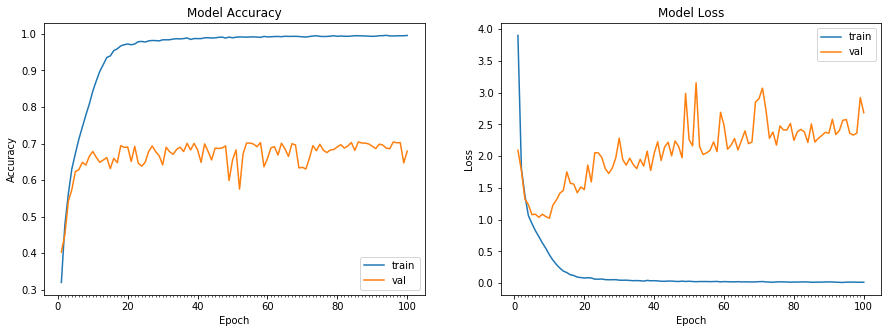

Accuracy on test data is: 67.94


In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))